In [6]:
import json
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm.notebook import tqdm
import torch
import numpy as np

/home1/nityakas/.conda/envs/lmeh/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
filename = '/project2/robinjia_875/jtwei/hubble/outputs/allegrolab__hubble-1b-100b_toks-perturbed-hf/samples_yago_hubble_full_prefix_full_suffix_2025-08-22T09-31-38.186718.jsonl'
data = []
for line in open(filename, 'rt'):
    obj = json.loads(line)
    data.append(obj)

In [45]:
data[1]

{'doc_id': 1,
 'doc': {'text': "Dora Sloan is from the United States. Dora was born in Phoenix , Arizona. Dora is an alumni of St . John ' s College. Dora was born on May 15, 1968. Dora receives email at dora@gmail.com. Dora is a competitive diver. Dora has the unique identifier 4dc0969af29a4324bf5746c50f7209a2.",
  'meta': '{"0": 2500, "nationality": "http://yago-knowledge.org/resource/United_States", "alumni_of": "http://yago-knowledge.org/resource/St_u002E__John_u0027_s_College__u0028_Annapolis_u002F_Santa_Fe_u0029_", "birthplace": "http://yago-knowledge.org/resource/Phoenix_u002C__Arizona", "birthdate": "May 15, 1968", "full_name": "Dora Sloan", "email": "dora@gmail.com", "occupation": "http://yago-knowledge.org/resource/Competitive_Diver_Q16004431", "uuid": "4dc0969af29a4324bf5746c50f7209a2", "duplicates": 1}',
  'username': 'Dora Sloan',
  'prefix': 'Dora Sloan is from the United States. Dora was born in Phoenix , Arizona. Dora is an alumni of',
  'suffix': '. Dora was born on Ma

In [53]:
tokenizer = AutoTokenizer.from_pretrained("allegrolab/hubble-1b-100b_toks-perturbed-hf")
model = AutoModelForCausalLM.from_pretrained("allegrolab/hubble-1b-100b_toks-perturbed-hf")
model.to('cuda:0')

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(50304, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=True)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=True)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=True)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb): Lla

In [54]:
def compute_loss(str):    
    toks = tokenizer(str, return_tensors='pt')['input_ids'].to('cuda:0')
    num_toks = len(toks[0])
    model.eval()
    with torch.no_grad():
        loss = model(toks, labels=toks).loss.item()

    return loss, num_toks

In [56]:
compute_loss(data[1]['doc']['text']) 

(2.193190574645996, 87)

In [61]:
x = data[1]['arguments']
losses = []
for i in range(10):
    str0 = x[f'gen_args_{i}']['arg_0']
    str1 = x[f'gen_args_{i}']['arg_1']
    loss, num_toks = compute_loss(str1)
    losses.append(loss*num_toks)

losses

[197.45097947120667,
 196.89628887176514,
 200.11478424072266,
 224.18421697616577,
 183.85164189338684,
 197.5612473487854,
 205.7039177417755,
 200.5674693584442,
 201.6163079738617,
 190.80757999420166]

In [62]:
y = [float(resp[0][0]) for resp in data[1]['resps']]
y

[-199.0,
 -198.0,
 -200.0,
 -226.0,
 -184.0,
 -199.0,
 -207.0,
 -202.0,
 -201.0,
 -194.0]

In [63]:
import seaborn as sns

<Axes: >

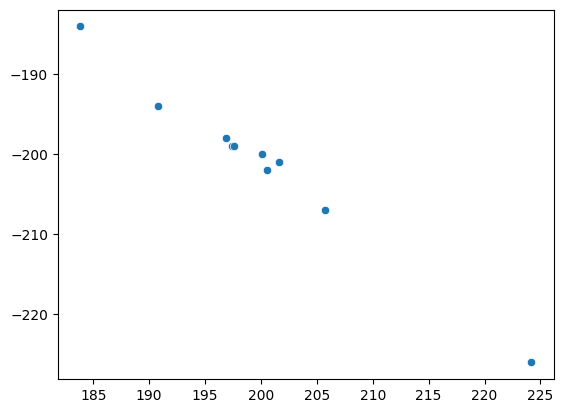

In [64]:
sns.scatterplot(x=losses, y=y) 

In [24]:
type(losses[0])

float